# Dinamična analiza #

In [1]:
import lvm_read
import numpy  as np
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import get_window
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams.update({'text.usetex': True,
                     'font.size': 31,
                     'font.family':'lmodern',})

In [2]:
class MeritevDinamike():
    ''' Take a .lvm file for analysis of ROC. '''
    def __init__(self, read_data):
        self.data = lvm_read.read(read_data)
    
    def sig(self):
        '''Returns signal[0] and signal length[1] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        return sig, N

    def time(self):
        '''Returns dt[0], fs[1] and total time[2] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        dt = self.data[0]['Delta_X'][0]
        fs = 1 / dt
        cajt = dt * np.arange(N)
        return dt, fs, cajt
    
    def instruments(self):
        '''
        Returns instrument data of measurment Class:
        0 - Vhodni pospeškomer [g]
        1 - Izhodni pospeškomer [g]
        '''
        # Pospešek (in)
        acc1 = self.data[0]['data'][:,0]
        # Pospešek (out)
        acc2 = self.data[0]['data'][:,1]
        
        return acc1, acc2

    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2) 

## Prenosnost $T(\omega)$ z numeriko ##

###  $T(\omega)$ za ROC=3 (prikaz deformacij in nihanj na MKE modelom)  ###

In [ ]:
## 3 ROC ##
# numerični model
ff = np.loadtxt("Mathematica/3ROC/E2399/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re = np.loadtxt("Mathematica/3ROC/E2399/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im = np.loadtxt("Mathematica/3ROC/E2399/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin = np.loadtxt("Mathematica/3ROC/E2399/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin = np.loadtxt("Mathematica/3ROC/E2399/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin = np.loadtxt("Mathematica/3ROC/E2399/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap = np.loadtxt("Mathematica/3ROC/E2399/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re = np.loadtxt("Mathematica/3ROC/E2399/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im = np.loadtxt("Mathematica/3ROC/E2399/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin = np.loadtxt("Mathematica/3ROC/E2399/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin = np.loadtxt("Mathematica/3ROC/E2399/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin = np.loadtxt("Mathematica/3ROC/E2399/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

In [ ]:
### Izris Abs(T)
plt.rcParams['figure.figsize'] = [16, 10]

# Numerika Mathematica

#ROC3
plt.plot(ff_lin, 20 * np.log10(np.abs(ft_Re_lin + ft_Im_lin*1j)), 
         linestyle="-", lw=3, color='tab:green', label=r'Prenosnost z linearizacijo')
plt.plot(ff, 20 * np.log10(np.abs(ft_Re + ft_Im*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color='tab:green', label=r'Prenosnost po metodi Runge-Kutta')

plt.axvspan(4.7, 5.7+5, alpha=0.15, color='grey')


plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(0, 1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.legend(loc='lower right')
plt.savefig('T_3ROC_1.pdf', format='pdf')
plt.show()

In [ ]:
### Izris Abs(T) pobližano
# Numerika Mathematica

#ROC3
plt.plot(ffgap_lin, 20 * np.log10(np.abs(ftgap_Re_lin + ftgap_Im_lin*1j)), 
         linestyle="-", lw=4, color='tab:green')
plt.plot(ffgap, 20 * np.log10(np.abs(ftgap_Re + ftgap_Im*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color='tab:green')


plt.axvspan(4.7, 5.7, alpha=0.15, color='grey', label='pasovna vrzel')


plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(0, 10)
plt.ylim(-13.99, -13.94)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.legend()
plt.savefig('T_3ROC_2.pdf', format='pdf')
plt.show()

### $T(\omega)$ pri različnem št. ROC v MM pri $E=2318$ MPa ###

In [ ]:
### import Mathematica ###

## 1 ROC ##
# numerični model
ff_1 = np.loadtxt("Mathematica/1ROC/E2318/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_1 = np.loadtxt("Mathematica/1ROC/E2318/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_1 = np.loadtxt("Mathematica/1ROC/E2318/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_1 = np.loadtxt("Mathematica/1ROC/E2318/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_1 = np.loadtxt("Mathematica/1ROC/E2318/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_1 = np.loadtxt("Mathematica/1ROC/E2318/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_1 = np.loadtxt("Mathematica/1ROC/E2318/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_1 = np.loadtxt("Mathematica/1ROC/E2318/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_1 = np.loadtxt("Mathematica/1ROC/E2318/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_1 = np.loadtxt("Mathematica/1ROC/E2318/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_1 = np.loadtxt("Mathematica/1ROC/E2318/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_1 = np.loadtxt("Mathematica/1ROC/E2318/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

## 3 ROC ##
# numerični model
ff_3 = np.loadtxt("Mathematica/3ROC/E2318/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_3 = np.loadtxt("Mathematica/3ROC/E2318/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_3 = np.loadtxt("Mathematica/3ROC/E2318/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_3 = np.loadtxt("Mathematica/3ROC/E2318/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_3 = np.loadtxt("Mathematica/3ROC/E2318/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_3 = np.loadtxt("Mathematica/3ROC/E2318/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_3 = np.loadtxt("Mathematica/3ROC/E2318/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_3 = np.loadtxt("Mathematica/3ROC/E2318/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_3 = np.loadtxt("Mathematica/3ROC/E2318/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_3 = np.loadtxt("Mathematica/3ROC/E2318/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_3 = np.loadtxt("Mathematica/3ROC/E2318/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_3 = np.loadtxt("Mathematica/3ROC/E2318/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

## 5 ROC ##
# numerični model
ff_5 = np.loadtxt("Mathematica/5ROC/E2318/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_5 = np.loadtxt("Mathematica/5ROC/E2318/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_5 = np.loadtxt("Mathematica/5ROC/E2318/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_5 = np.loadtxt("Mathematica/5ROC/E2318/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_5 = np.loadtxt("Mathematica/5ROC/E2318/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_5 = np.loadtxt("Mathematica/5ROC/E2318/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_5 = np.loadtxt("Mathematica/5ROC/E2318/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_5 = np.loadtxt("Mathematica/5ROC/E2318/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_5 = np.loadtxt("Mathematica/5ROC/E2318/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_5 = np.loadtxt("Mathematica/5ROC/E2318/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_5 = np.loadtxt("Mathematica/5ROC/E2318/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_5 = np.loadtxt("Mathematica/5ROC/E2318/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

## 10 ROC ##
# numerični model
ff_10 = np.loadtxt("Mathematica/10ROC/E2318/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_10 = np.loadtxt("Mathematica/10ROC/E2318/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_10 = np.loadtxt("Mathematica/10ROC/E2318/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_10 = np.loadtxt("Mathematica/10ROC/E2318/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_10 = np.loadtxt("Mathematica/10ROC/E2318/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_10 = np.loadtxt("Mathematica/10ROC/E2318/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_10 = np.loadtxt("Mathematica/10ROC/E2318/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_10 = np.loadtxt("Mathematica/10ROC/E2318/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_10 = np.loadtxt("Mathematica/10ROC/E2318/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_10 = np.loadtxt("Mathematica/10ROC/E2318/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_10 = np.loadtxt("Mathematica/10ROC/E2318/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_10 = np.loadtxt("Mathematica/10ROC/E2318/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

In [ ]:
### Izris Abs(T)
plt.rcParams['figure.figsize'] = [16, 10]
c1 = "tab:red"
c2 = "tab:green"
m = 3

# Numerika Mathematica

#ROC1
plt.plot(ff_lin_1, 20 * np.log10(np.abs(ft_Re_lin_1 + ft_Im_lin_1*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 0/m), label=r'št. ROC $= 1$')
plt.plot(ff_1, 20 * np.log10(np.abs(ft_Re_1 + ft_Im_1*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color=colorFader(c1,c2, 0/m))

#ROC3
plt.plot(ff_lin_3, 20 * np.log10(np.abs(ft_Re_lin_3 + ft_Im_lin_3*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 1/m), label=r'št. ROC $= 3$')
plt.plot(ff_3, 20 * np.log10(np.abs(ft_Re_3 + ft_Im_3*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color=colorFader(c1,c2, 1/m))

#ROC5
plt.plot(ff_lin_5, 20 * np.log10(np.abs(ft_Re_lin_5 + ft_Im_lin_5*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 2/m), label=r'št. ROC $= 5$')
plt.plot(ff_5, 20 * np.log10(np.abs(ft_Re_5 + ft_Im_5*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color=colorFader(c1,c2, 2/m))

#ROC10
plt.plot(ff_lin_10, 20 * np.log10(np.abs(ft_Re_lin_10 + ft_Im_lin_10*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 3/m), label=r'št. ROC $= 10$')
plt.plot(ff_10, 20 * np.log10(np.abs(ft_Re_10 + ft_Im_10*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color=colorFader(c1,c2, 3/m))


plt.axvspan(40, 63, alpha=0.15, color='grey', label='pasovna vrzel')


plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(0, 1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.legend(loc='lower right')
plt.savefig('T_ROCn_1.pdf', format='pdf')
plt.show()

In [ ]:
### Izris Abs(T) pobližano
# Numerika Mathematica

#ROC1
plt.plot(ffgap_lin_1, 20 * np.log10(np.abs(ftgap_Re_lin_1 + ftgap_Im_lin_1*1j)), 
         linestyle="-", lw=3, color=colorFader(c1,c2, 0/m))
plt.plot(ffgap_1, 20 * np.log10(np.abs(ftgap_Re_1 + ftgap_Im_1*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color=colorFader(c1,c2, 0/m))

#ROC3
plt.plot(ffgap_lin_3, 20 * np.log10(np.abs(ftgap_Re_lin_3 + ftgap_Im_lin_3*1j)), 
         linestyle="-", lw=3, color=colorFader(c1,c2, 1/m))
plt.plot(ffgap_3, 20 * np.log10(np.abs(ftgap_Re_3 + ftgap_Im_3*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color=colorFader(c1,c2, 1/m))

#ROC5
plt.plot(ffgap_lin_5, 20 * np.log10(np.abs(ftgap_Re_lin_5 + ftgap_Im_lin_5*1j)), 
         linestyle="-", lw=3, color=colorFader(c1,c2, 2/m))
plt.plot(ffgap_5, 20 * np.log10(np.abs(ftgap_Re_5 + ftgap_Im_5*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color=colorFader(c1,c2, 2/m))

#ROC10
plt.plot(ffgap_lin_10, 20 * np.log10(np.abs(ftgap_Re_lin_10 + ftgap_Im_lin_10*1j)), 
         linestyle="-", lw=3, color=colorFader(c1,c2, 3/m))
plt.plot(ffgap_10, 20 * np.log10(np.abs(ftgap_Re_10 + ftgap_Im_5*1j)), 
         linestyle="-.", lw=1, alpha=0.7, color=colorFader(c1,c2, 3/m))

plt.axvspan(42.4, 44, alpha=0.15, color=colorFader(c1,c2, 0/m))
plt.axvspan(42.0, 46, alpha=0.15, color=colorFader(c1,c2, 1/m))
plt.axvspan(41.6, 48, alpha=0.15, color=colorFader(c1,c2, 2/m))
plt.axvspan(41.0, 59, alpha=0.15, color=colorFader(c1,c2, 3/m))


plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(30, 80)
plt.ylim(-40, 10)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.savefig('T_ROCn_2.pdf', format='pdf')
plt.show()

### $T(\omega)$ pri različnih temperaturah MM za ROC=3  ###

In [ ]:
### import Mathematica ###
#[2399, 2378, 2355, 2318, 2280, 2240, 2200, 2140, 2080]

# 2400 MPa
# numerični model
ff_1 = np.loadtxt("Mathematica/3ROC/E2399/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_1 = np.loadtxt("Mathematica/3ROC/E2399/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_1 = np.loadtxt("Mathematica/3ROC/E2399/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_1 = np.loadtxt("Mathematica/3ROC/E2399/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_1 = np.loadtxt("Mathematica/3ROC/E2399/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_1 = np.loadtxt("Mathematica/3ROC/E2399/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2378 MPa
# numerični model
ff_2 = np.loadtxt("Mathematica/3ROC/E2378/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_2 = np.loadtxt("Mathematica/3ROC/E2378/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_2 = np.loadtxt("Mathematica/3ROC/E2378/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_2 = np.loadtxt("Mathematica/3ROC/E2378/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_2 = np.loadtxt("Mathematica/3ROC/E2378/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_2 = np.loadtxt("Mathematica/3ROC/E2378/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2355 MPa
# numerični model
ff_3 = np.loadtxt("Mathematica/3ROC/E2355/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_3 = np.loadtxt("Mathematica/3ROC/E2355/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_3 = np.loadtxt("Mathematica/3ROC/E2355/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_3 = np.loadtxt("Mathematica/3ROC/E2355/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_3 = np.loadtxt("Mathematica/3ROC/E2355/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_3 = np.loadtxt("Mathematica/3ROC/E2355/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2318 MPa
# numerični model
ff_4 = np.loadtxt("Mathematica/3ROC/E2318/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_4 = np.loadtxt("Mathematica/3ROC/E2318/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_4 = np.loadtxt("Mathematica/3ROC/E2318/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_4 = np.loadtxt("Mathematica/3ROC/E2318/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_4 = np.loadtxt("Mathematica/3ROC/E2318/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_4 = np.loadtxt("Mathematica/3ROC/E2318/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2280 MPa
# numerični model
ff_5 = np.loadtxt("Mathematica/3ROC/E2280/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_5 = np.loadtxt("Mathematica/3ROC/E2280/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_5 = np.loadtxt("Mathematica/3ROC/E2280/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_5 = np.loadtxt("Mathematica/3ROC/E2280/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_5 = np.loadtxt("Mathematica/3ROC/E2280/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_5 = np.loadtxt("Mathematica/3ROC/E2280/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2240 MPa
# numerični model
ff_6 = np.loadtxt("Mathematica/3ROC/E2240/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_6 = np.loadtxt("Mathematica/3ROC/E2240/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_6 = np.loadtxt("Mathematica/3ROC/E2240/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_6 = np.loadtxt("Mathematica/3ROC/E2240/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_6 = np.loadtxt("Mathematica/3ROC/E2240/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_6 = np.loadtxt("Mathematica/3ROC/E2240/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2200 MPa
# numerični model
ff_7 = np.loadtxt("Mathematica/3ROC/E2200/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_7 = np.loadtxt("Mathematica/3ROC/E2200/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_7 = np.loadtxt("Mathematica/3ROC/E2200/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_7 = np.loadtxt("Mathematica/3ROC/E2200/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_7 = np.loadtxt("Mathematica/3ROC/E2200/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_7 = np.loadtxt("Mathematica/3ROC/E2200/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2140 MPa
# numerični model
ff_8 = np.loadtxt("Mathematica/3ROC/E2140/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_8 = np.loadtxt("Mathematica/3ROC/E2140/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_8 = np.loadtxt("Mathematica/3ROC/E2140/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_8 = np.loadtxt("Mathematica/3ROC/E2140/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_8 = np.loadtxt("Mathematica/3ROC/E2140/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_8 = np.loadtxt("Mathematica/3ROC/E2140/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2080 MPa
# numerični model
ff_9 = np.loadtxt("Mathematica/3ROC/E2080/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_9 = np.loadtxt("Mathematica/3ROC/E2080/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_9 = np.loadtxt("Mathematica/3ROC/E2080/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_9 = np.loadtxt("Mathematica/3ROC/E2080/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_9 = np.loadtxt("Mathematica/3ROC/E2080/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_9 = np.loadtxt("Mathematica/3ROC/E2080/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# Skupno
ff_i = [ff_1, ff_2, ff_3, ff_4, ff_5, ff_6, ff_7, ff_8, ff_9]
ft_Re_i  = [ft_Re_1, ft_Re_2, ft_Re_3, ft_Re_4, ft_Re_5, ft_Re_6, ft_Re_7, ft_Re_8, ft_Re_9]
ft_Im_i = [ft_Im_1, ft_Im_2, ft_Im_3, ft_Im_4, ft_Im_5, ft_Im_6, ft_Im_7, ft_Im_8, ft_Im_9]
ff_lin_i = [ff_lin_1, ff_lin_2, ff_lin_3, ff_lin_4, ff_lin_5, ff_lin_6, ff_lin_7, ff_lin_8, ff_lin_9]
ft_Re_lin_i = [ft_Re_lin_1, ft_Re_lin_2, ft_Re_lin_3, ft_Re_lin_4, ft_Re_lin_5, ft_Re_lin_6, ft_Re_lin_7, ft_Re_lin_8, ft_Re_lin_9]
ft_Im_lin_i = [ft_Im_lin_1, ft_Im_lin_2, ft_Im_lin_3, ft_Im_lin_4, ft_Im_lin_5, ft_Im_lin_6, ft_Im_lin_7, ft_Im_lin_8, ft_Im_lin_9]

In [ ]:
### Izris Abs(T)
plt.rcParams['figure.figsize'] = [16, 10]
# Color bar
T_values = [22.0, 23.5, 25.0, 27.5, 30.0, 32.5, 35.0, 37.5, 40.0]
N = len(T_values)
cmap = plt.get_cmap('inferno',N)
norm = mpl.colors.Normalize(vmin=T_values[0],vmax=T_values[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Numerika Mathematica

for i in range(len(T_values)):
    plt.plot(ff_lin_i[i], 20 * np.log10(np.abs(ft_Re_lin_i[i] + ft_Im_lin_i[i]*1j)), linestyle="-", lw=2, color=cmap(i))
    plt.plot(ff_i[i], 20 * np.log10(np.abs(ft_Re_i[i] + ft_Im_i[i]*1j)), linestyle="-.", lw=1, alpha=0.7, color=cmap(i))


# pasovna vrzel
plt.axvspan(20, 90, alpha=0.15, color='grey')

plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(0, 1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.savefig('T_ROC3_dT_1.pdf', format='pdf')
plt.show()

In [ ]:
### import Mathematica Closeup ###
#[2399, 2378, 2355, 2318, 2280, 2240, 2200, 2140, 2080]

# 2400 MPa
# numerični model
ff_1 = np.loadtxt("Mathematica/3ROC/E2399/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_1 = np.loadtxt("Mathematica/3ROC/E2399/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_1 = np.loadtxt("Mathematica/3ROC/E2399/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_1 = np.loadtxt("Mathematica/3ROC/E2399/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_1 = np.loadtxt("Mathematica/3ROC/E2399/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_1 = np.loadtxt("Mathematica/3ROC/E2399/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2378 MPa
# numerični model
ff_2 = np.loadtxt("Mathematica/3ROC/E2378/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_2 = np.loadtxt("Mathematica/3ROC/E2378/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_2 = np.loadtxt("Mathematica/3ROC/E2378/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_2 = np.loadtxt("Mathematica/3ROC/E2378/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_2 = np.loadtxt("Mathematica/3ROC/E2378/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_2 = np.loadtxt("Mathematica/3ROC/E2378/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2355 MPa
# numerični model
ff_3 = np.loadtxt("Mathematica/3ROC/E2355/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_3 = np.loadtxt("Mathematica/3ROC/E2355/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_3 = np.loadtxt("Mathematica/3ROC/E2355/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_3 = np.loadtxt("Mathematica/3ROC/E2355/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_3 = np.loadtxt("Mathematica/3ROC/E2355/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_3 = np.loadtxt("Mathematica/3ROC/E2355/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2318 MPa
# numerični model
ff_4 = np.loadtxt("Mathematica/3ROC/E2318/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_4 = np.loadtxt("Mathematica/3ROC/E2318/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_4 = np.loadtxt("Mathematica/3ROC/E2318/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_4 = np.loadtxt("Mathematica/3ROC/E2318/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_4 = np.loadtxt("Mathematica/3ROC/E2318/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_4 = np.loadtxt("Mathematica/3ROC/E2318/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2280 MPa
# numerični model
ff_5 = np.loadtxt("Mathematica/3ROC/E2280/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_5 = np.loadtxt("Mathematica/3ROC/E2280/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_5 = np.loadtxt("Mathematica/3ROC/E2280/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_5 = np.loadtxt("Mathematica/3ROC/E2280/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_5 = np.loadtxt("Mathematica/3ROC/E2280/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_5 = np.loadtxt("Mathematica/3ROC/E2280/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2240 MPa
# numerični model
ff_6 = np.loadtxt("Mathematica/3ROC/E2240/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_6 = np.loadtxt("Mathematica/3ROC/E2240/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_6 = np.loadtxt("Mathematica/3ROC/E2240/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_6 = np.loadtxt("Mathematica/3ROC/E2240/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_6 = np.loadtxt("Mathematica/3ROC/E2240/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_6 = np.loadtxt("Mathematica/3ROC/E2240/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2200 MPa
# numerični model
ff_7 = np.loadtxt("Mathematica/3ROC/E2200/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_7 = np.loadtxt("Mathematica/3ROC/E2200/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_7 = np.loadtxt("Mathematica/3ROC/E2200/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_7 = np.loadtxt("Mathematica/3ROC/E2200/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_7 = np.loadtxt("Mathematica/3ROC/E2200/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_7 = np.loadtxt("Mathematica/3ROC/E2200/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2140 MPa
# numerični model
ff_8 = np.loadtxt("Mathematica/3ROC/E2140/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_8 = np.loadtxt("Mathematica/3ROC/E2140/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_8 = np.loadtxt("Mathematica/3ROC/E2140/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_8 = np.loadtxt("Mathematica/3ROC/E2140/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_8 = np.loadtxt("Mathematica/3ROC/E2140/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_8 = np.loadtxt("Mathematica/3ROC/E2140/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2080 MPa
# numerični model
ff_9 = np.loadtxt("Mathematica/3ROC/E2080/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_9 = np.loadtxt("Mathematica/3ROC/E2080/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_9 = np.loadtxt("Mathematica/3ROC/E2080/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_9 = np.loadtxt("Mathematica/3ROC/E2080/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_9 = np.loadtxt("Mathematica/3ROC/E2080/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_9 = np.loadtxt("Mathematica/3ROC/E2080/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)


ffgap_i = [ff_1, ff_2, ff_3, ff_4, ff_5, ff_6, ff_7, ff_8, ff_9]
ftgap_Re_i  = [ft_Re_1, ft_Re_2, ft_Re_3, ft_Re_4, ft_Re_5, ft_Re_6, ft_Re_7, ft_Re_8, ft_Re_9]
ftgap_Im_i = [ft_Im_1, ft_Im_2, ft_Im_3, ft_Im_4, ft_Im_5, ft_Im_6, ft_Im_7, ft_Im_8, ft_Im_9]
ffgap_lin_i = [ff_lin_1, ff_lin_2, ff_lin_3, ff_lin_4, ff_lin_5, ff_lin_6, ff_lin_7, ff_lin_8, ff_lin_9]
ftgap_Re_lin_i = [ft_Re_lin_1, ft_Re_lin_2, ft_Re_lin_3, ft_Re_lin_4, ft_Re_lin_5, ft_Re_lin_6, ft_Re_lin_7, ft_Re_lin_8, ft_Re_lin_9]
ftgap_Im_lin_i = [ft_Im_lin_1, ft_Im_lin_2, ft_Im_lin_3, ft_Im_lin_4, ft_Im_lin_5, ft_Im_lin_6, ft_Im_lin_7, ft_Im_lin_8, ft_Im_lin_9]

In [ ]:
### Izris Abs(T)
plt.rcParams['figure.figsize'] = [16, 10]
# Color bar
T_values = [22.0, 23.5, 25.0, 27.5, 30.0, 32.5, 35.0, 37.5, 40.0]
N = len(T_values)
cmap = plt.get_cmap('inferno',N)
norm = mpl.colors.Normalize(vmin=T_values[0],vmax=T_values[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Numerika Mathematica

for i in range(len(T_values)):
    plt.plot(ffgap_lin_i[i], 20 * np.log10(np.abs(ftgap_Re_lin_i[i] + ftgap_Im_lin_i[i]*1j)), linestyle="-", lw=3, color=cmap(i))
    plt.plot(ffgap_i[i], 20 * np.log10(np.abs(ftgap_Re_i[i] + ftgap_Im_i[i]*1j)), linestyle="-.", lw=1, alpha=0.7, color=cmap(i))

    

plt.axvspan(6, 7.5, alpha=0.15, color=cmap(0))
plt.axvspan(22, 24, alpha=0.15, color=cmap(1))
plt.axvspan(31.5, 34, alpha=0.15, color=cmap(2))
plt.axvspan(42.7, 47, alpha=0.15, color=cmap(3))
plt.axvspan(51.5, 56, alpha=0.15, color=cmap(4))
plt.axvspan(59, 64, alpha=0.15, color=cmap(5))
plt.axvspan(66, 72, alpha=0.15, color=cmap(6))
plt.axvspan(74.5, 80, alpha=0.15, color=cmap(7))
plt.axvspan(83, 91, alpha=0.15, color=cmap(8))
    
plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=9)
plt.xlim(0, 110)
#plt.ylim(-40, 20)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.colorbar(sm, ticks=np.linspace(22,T_values[-1],int(N/2)), 
             boundaries=np.arange(T_values[0]-0.1,T_values[-1]+0.1,.01)
            ).set_label(r'Temperatura.$[^\circ$C]', labelpad=0.5, y=0.5, rotation=90)
plt.savefig('T_ROC3_dT_2.pdf', format='pdf')
plt.show()

## Prenosnost $T(\omega)$ eksperimentalno ##

### $T(\omega)$ pri različnem št. ROC v MM  ###

In [3]:
# Esperiment
data_1 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_set4.lvm')
data_2 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_set4.lvm')
data_3 = MeritevDinamike('Analiza/5ROC/MM_T21_roc5_set1.lvm')
data_4 = MeritevDinamike('Analiza/6ROC/MM_T21_roc6_set1.lvm')

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


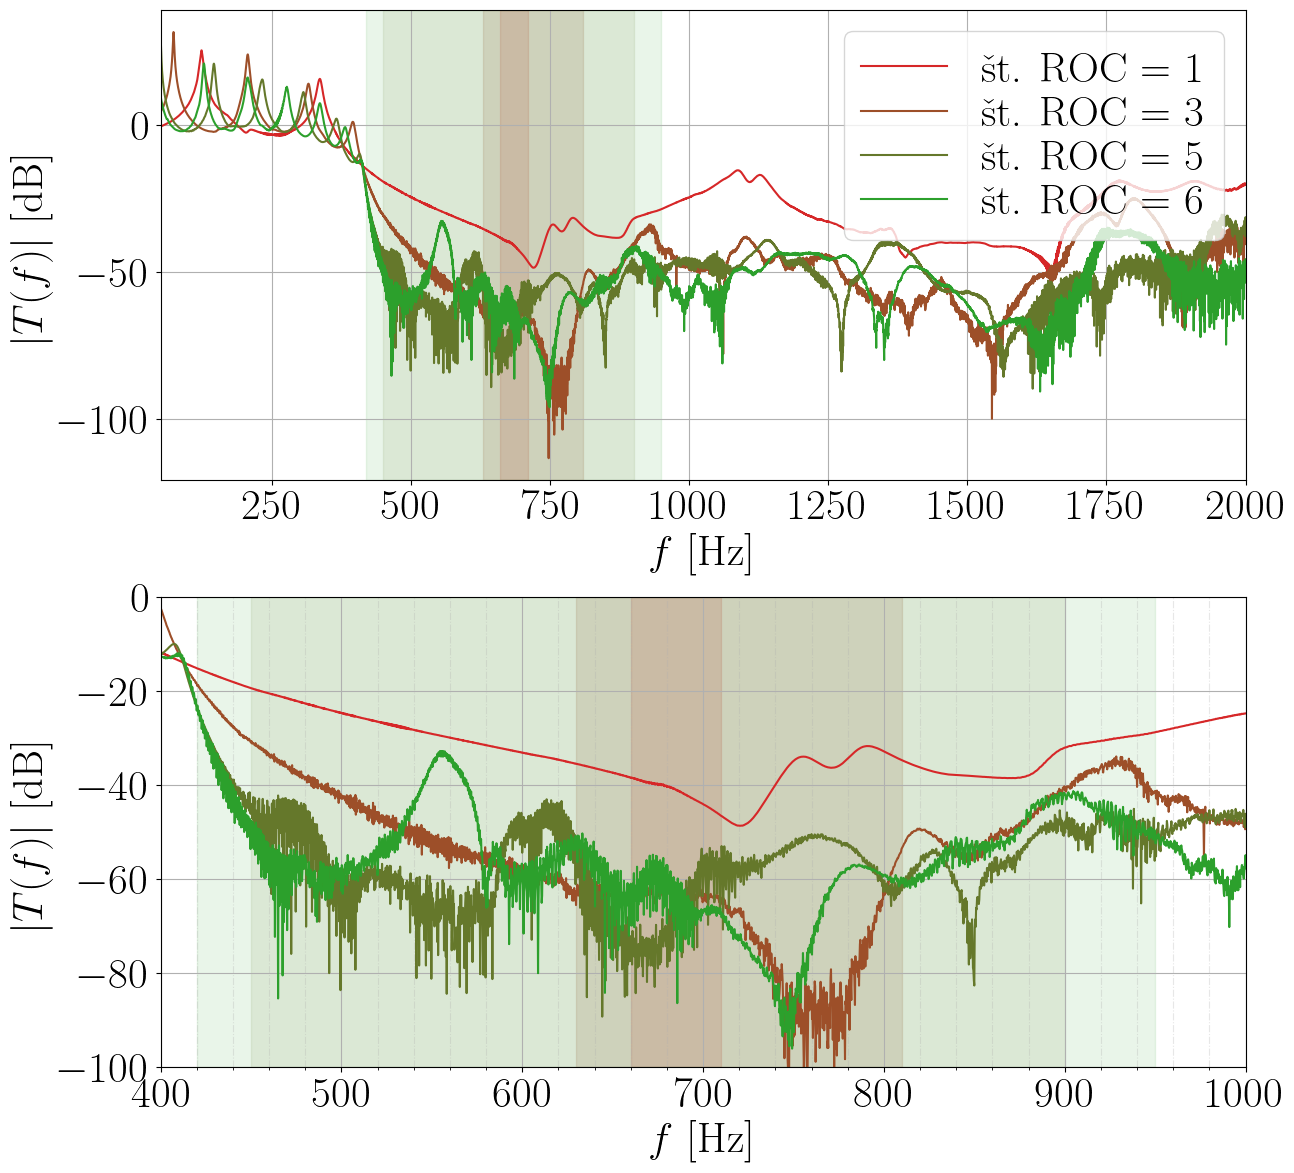

In [4]:
plt.rcParams['figure.figsize'] = [14, 14]
fig, axs = plt.subplots(2, sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.25)

# Podatki
data_group = [data_1, data_2, data_3, data_4]
ROC_nr = [1,3,5,6]
i = 0
m = len(data_group)-1

c1 = "tab:red"
c2 = "tab:green"

for data_j in data_group:
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    g_output = data_j.instruments()[1]
     
    t_1 = int(t_start*len(time)/time[-1])
    t_2 = int((t_start+t_step)*len(time)/time[-1])
    
    # Prenosna funkcija
    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], g_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    axs[0].plot(xf, 20 * np.log10(np.abs(H1)), linewidth=1.5, linestyle='-', alpha=1, label=f'št. ROC = {ROC_nr[i]}', color=colorFader(c1,c2, i/m))
    axs[1].plot(xf, 20 * np.log10(np.abs(H1)), linewidth=1.5, linestyle='-', alpha=1, color=colorFader(c1,c2, i/m))
    
    i+=1
    

axs[0].axvspan(660, 710, alpha=0.15, color=colorFader(c1,c2, 0/m))
axs[1].axvspan(660, 710, alpha=0.15, color=colorFader(c1,c2, 0/m))
axs[0].axvspan(630, 810, alpha=0.15, color=colorFader(c1,c2, 1/m))
axs[1].axvspan(630, 810, alpha=0.15, color=colorFader(c1,c2, 1/m))
axs[0].axvspan(450, 900, alpha=0.1, color=colorFader(c1,c2, 2/m))
axs[1].axvspan(450, 900, alpha=0.1, color=colorFader(c1,c2, 2/m))
axs[0].axvspan(420, 950, alpha=0.1, color=colorFader(c1,c2, 3/m))
axs[1].axvspan(420, 950, alpha=0.1, color=colorFader(c1,c2, 3/m))
    
axs[0].set_xlim(50, 2000)
axs[1].set_xlim(400, 1000)
axs[1].set_ylim(-100, 0)
axs[0].set_xlabel(r'$f$ [Hz]')
axs[1].set_xlabel(r'$f$ [Hz]')
axs[0].set_ylabel(r'$|T(f)|$ [dB]')
axs[1].set_ylabel(r'$|T(f)|$ [dB]')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.rcParams.update({'legend.labelspacing':0.05})
axs[0].grid()
axs[1].grid()
axs[0].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[1].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[0].legend(loc='upper right')
#plt.xticks(x_ticks)
plt.savefig('FRF_eksperiment.pdf', format='pdf')
plt.show();

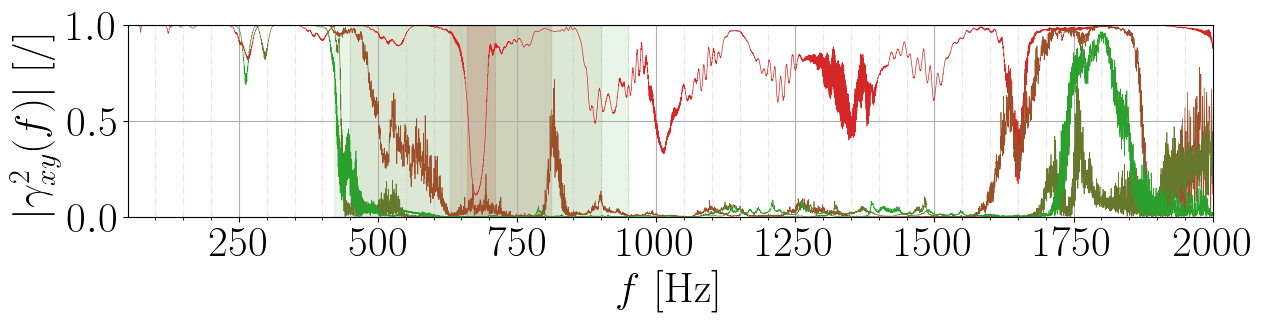

In [5]:
# Koherenca
plt.rcParams['figure.figsize'] = [14, 4]
plt.gcf().subplots_adjust(bottom=0.4)

i = 0

for data_j in data_group:
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    F_output = data_j.instruments()[1]

    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pyy = signal.csd(F_output[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    H2 = Pyy / Pxy
    coh = H1/H2
    plt.plot(xf, np.abs(coh), linewidth=0.5, linestyle='-', alpha=1, label=f'MM {i+1}', color=colorFader(c1,c2, i/m))
    
    i+=1

plt.axvspan(660, 710, alpha=0.15, color=colorFader(c1,c2, 0/m))
plt.axvspan(630, 810, alpha=0.15, color=colorFader(c1,c2, 1/m))
plt.axvspan(450, 900, alpha=0.1, color=colorFader(c1,c2, 2/m))
plt.axvspan(420, 950, alpha=0.1, color=colorFader(c1,c2, 3/m))

plt.xlim(50, 2000)
plt.ylim(0,1)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$|\gamma^2_{xy}(f)|$ [/]')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.rcParams.update({'legend.labelspacing':0.05})
#plt.legend(ncol=1, prop={'size': 31})
plt.grid()
plt.grid(which='minor', linestyle = '-.', alpha=0.3)
#x_ticks = np.arange(50, 2000, 500)
#plt.xticks(x_ticks)
plt.savefig('koherenca.pdf', format='pdf')
plt.show();

### $T(\omega)$ za pozitivni ROC  ###

In [6]:
# Esperiment
data_1 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_positive_only.lvm')
data_2 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_positive_only.lvm')

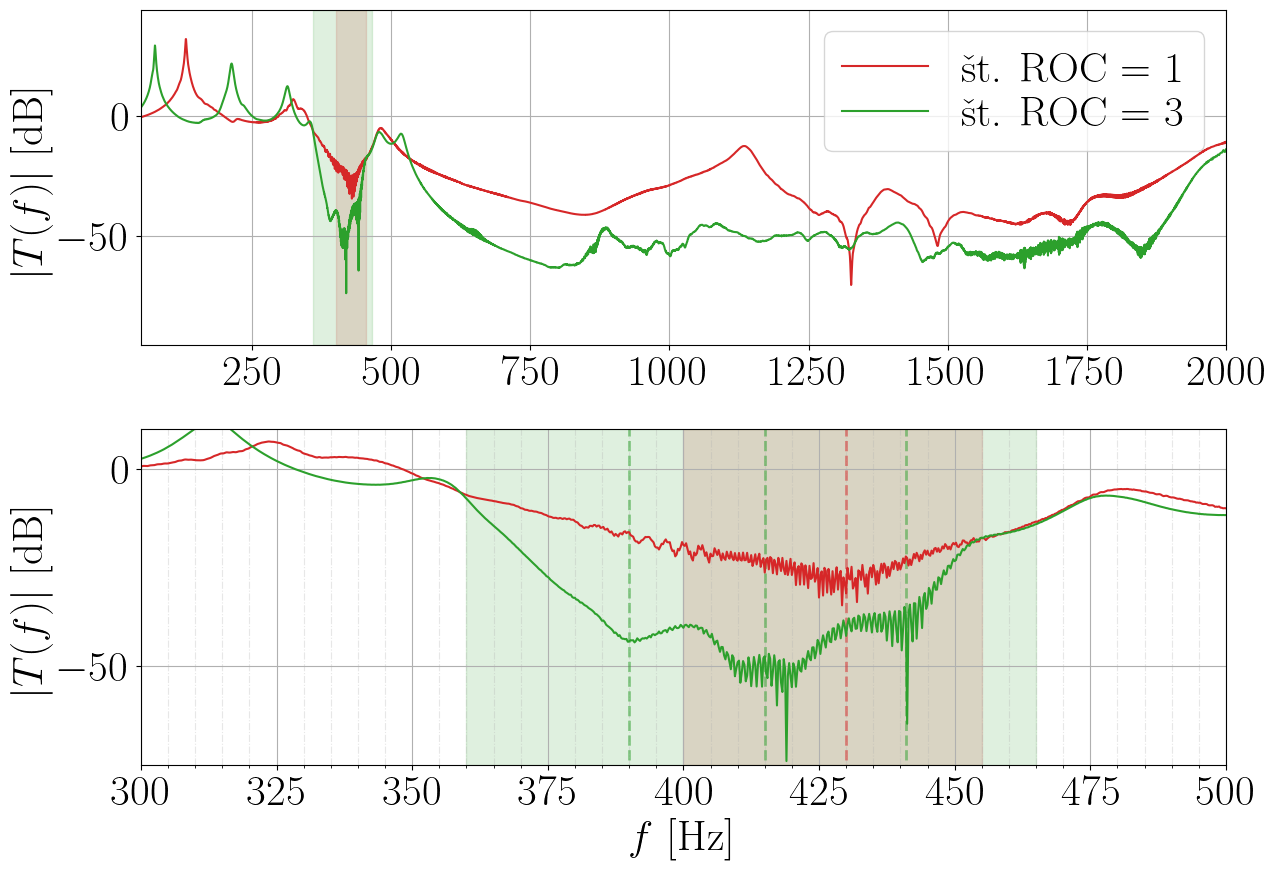

In [7]:
plt.rcParams['figure.figsize'] = [14, 10]
fig, axs = plt.subplots(2, sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.25)

# Podatki
data_group = [data_1, data_2]
ROC_nr = [1,3]
i = 0
m = len(data_group)-1

c1 = "tab:red"
c2 = "tab:green"

for data_j in data_group:
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    g_output = data_j.instruments()[1]
     
    t_1 = int(t_start*len(time)/time[-1])
    t_2 = int((t_start+t_step)*len(time)/time[-1])
    
    # Prenosna funkcija
    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], g_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    axs[0].plot(xf, 20 * np.log10(np.abs(H1)), linewidth=1.5, linestyle='-', alpha=1, label=f'št. ROC = {ROC_nr[i]}', color=colorFader(c1,c2, i/m))
    axs[1].plot(xf, 20 * np.log10(np.abs(H1)), linewidth=1.5, linestyle='-', alpha=1, color=colorFader(c1,c2, i/m))
    
    i+=1

    
axs[0].axvspan(400, 455, alpha=0.15, color=colorFader(c1,c2, 0/m))
axs[1].axvspan(400, 455, alpha=0.15, color=colorFader(c1,c2, 0/m)) 
axs[0].axvspan(360, 465, alpha=0.15, color=colorFader(c1,c2, 1/m))
axs[1].axvspan(360, 465, alpha=0.15, color=colorFader(c1,c2, 1/m)) 

axs[1].vlines(430, ymin=-100, ymax=100, alpha=0.5, linestyle='dashed', linewidth=2, color=colorFader(c1,c2, 0/m))

axs[1].vlines(390, ymin=-100, ymax=100, alpha=0.5, linestyle='dashed', linewidth=2, color=colorFader(c1,c2, 1/m))
axs[1].vlines(415, ymin=-100, ymax=100, alpha=0.5, linestyle='dashed', linewidth=2, color=colorFader(c1,c2, 1/m))
axs[1].vlines(441, ymin=-100, ymax=100, alpha=0.5, linestyle='dashed', linewidth=2, color=colorFader(c1,c2, 1/m))
    
axs[0].set_xlim(50, 2000)
axs[1].set_xlim(300, 500)
axs[1].set_ylim(-75, 10)
axs[1].set_xlabel(r'$f$ [Hz]')
axs[0].set_ylabel(r'$|T(f)|$ [dB]')
axs[1].set_ylabel(r'$|T(f)|$ [dB]')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.rcParams.update({'legend.labelspacing':0.05})
axs[0].grid()
axs[1].grid()
axs[0].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[1].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[0].legend(loc='upper right')
#plt.xticks(x_ticks)
plt.savefig('FRF_eksperiment_pozitivna.pdf', format='pdf')
plt.show();

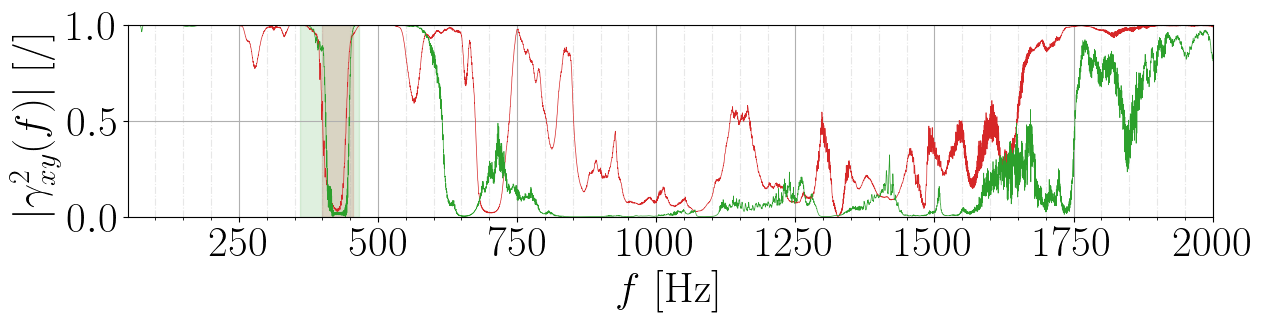

In [8]:
# Koherenca
plt.rcParams['figure.figsize'] = [14, 4]
plt.gcf().subplots_adjust(bottom=0.4)

i = 0

for data_j in data_group:
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    F_output = data_j.instruments()[1]

    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pyy = signal.csd(F_output[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    H2 = Pyy / Pxy
    coh = H1/H2
    plt.plot(xf, np.abs(coh), linewidth=0.5, linestyle='-', alpha=1, label=f'MM {i+1}', color=colorFader(c1,c2, i/m))
    
    i+=1

plt.axvspan(400, 455, alpha=0.15, color=colorFader(c1,c2, 0/m))
plt.axvspan(360, 465, alpha=0.15, color=colorFader(c1,c2, 1/m))
    
plt.xlim(50, 2000)
plt.ylim(0,1)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$|\gamma^2_{xy}(f)|$ [/]')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.rcParams.update({'legend.labelspacing':0.05})
#plt.legend(ncol=1, prop={'size': 31})
plt.grid()
plt.grid(which='minor', linestyle = '-.', alpha=0.3)
#x_ticks = np.arange(50, 2000, 500)
#plt.xticks(x_ticks)
plt.savefig('koherenca_pozitivna.pdf', format='pdf')
plt.show();

## Primerjava eksperimenta in numerike  ##

In [9]:
### Eksperimentalni podatki ###

data_1 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_set4.lvm')
data_2 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_set4.lvm')
data_3 = MeritevDinamike('Analiza/5ROC/MM_T21_roc5_set1.lvm')

### Numerični podatki ###

## 1 ROC ##
# numerični model lineariziran
ff_lin_1 = np.loadtxt("Mathematica/Primerjava/1ROC/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_1 = np.loadtxt("Mathematica/Primerjava/1ROC/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_1 = np.loadtxt("Mathematica/Primerjava/1ROC/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

## 3 ROC ##
# numerični model lineariziran
ff_lin_3 = np.loadtxt("Mathematica/Primerjava/3ROC/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_3 = np.loadtxt("Mathematica/Primerjava/3ROC/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_3 = np.loadtxt("Mathematica/Primerjava/3ROC/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

## 5 ROC ##
# numerični model lineariziran
ff_lin_5 = np.loadtxt("Mathematica/Primerjava/5ROC/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_5 = np.loadtxt("Mathematica/Primerjava/5ROC/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_5 = np.loadtxt("Mathematica/Primerjava/5ROC/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# Skupno
ff_lin_i = [ff_lin_1, ff_lin_3, ff_lin_5]
ft_Re_lin_i = [ft_Re_lin_1, ft_Re_lin_3, ft_Re_lin_5]
ft_Im_lin_i = [ft_Im_lin_1, ft_Im_lin_3, ft_Im_lin_5]

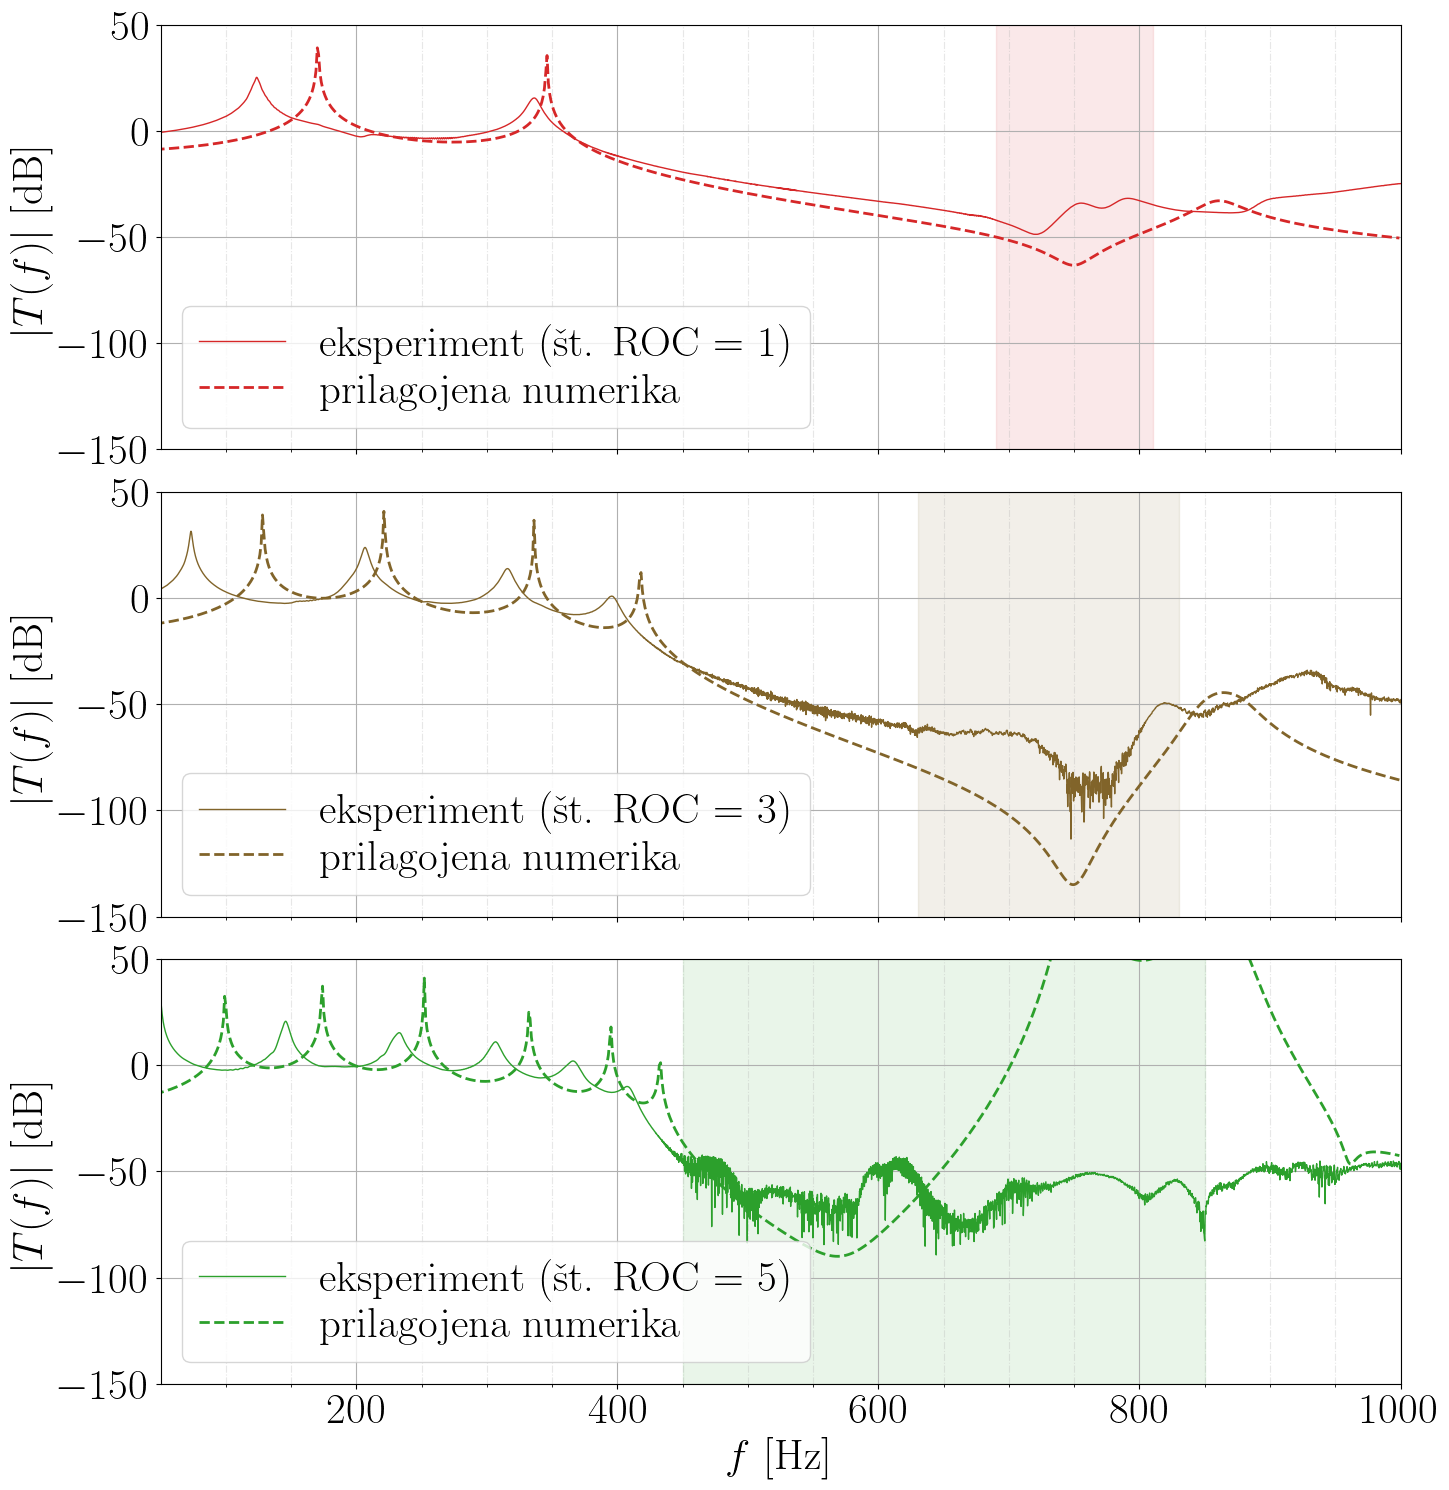

In [12]:
plt.rcParams['figure.figsize'] = [16, 18]
fig, axs = plt.subplots(3, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

# Podatki
data_group = [data_1, data_2, data_3]
ROC_nr = [1,3,5]
i = 0
m = len(data_group)-1

c1 = "tab:red"
c2 = "tab:green"

for data_j in data_group:
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    g_output = data_j.instruments()[1]
     
    t_1 = int(t_start*len(time)/time[-1])
    t_2 = int((t_start+t_step)*len(time)/time[-1])
    
    # Prenosna funkcija
    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], g_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    axs[i].plot(xf, 20 * np.log10(np.abs(H1)), linewidth=1, linestyle='-', alpha=1, label=f'eksperiment (št. ROC = {ROC_nr[i]})', color=colorFader(c1,c2, i/m))
    
    # Numerika
    axs[i].plot(ff_lin_i[i], 20 * np.log10(np.abs(ft_Re_lin_i[i] + ft_Im_lin_i[i]*1j)), linestyle="--", lw=2, color=colorFader(c1,c2, i/m), label=f'prilagojena numerika')

    i+=1

axs[0].axvspan(690, 810, alpha=0.1, color=colorFader(c1,c2, 0/m))
axs[1].axvspan(630, 830, alpha=0.1, color=colorFader(c1,c2, 1/m))
axs[2].axvspan(450, 850, alpha=0.1, color=colorFader(c1,c2, 2/m))
    
axs[0].set_xlim(50, 1000)
axs[0].set_ylim(-150, 50)
axs[2].set_xlabel(r'$f$ [Hz]')
axs[0].set_ylabel(r'$|T(f)|$ [dB]')
axs[1].set_ylabel(r'$|T(f)|$ [dB]')
axs[2].set_ylabel(r'$|T(f)|$ [dB]')
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[0].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[1].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[2].grid(which='minor', linestyle = '-.', alpha=0.3)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.rcParams.update({'legend.labelspacing':0.05})
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[2].legend(loc='best')
plt.savefig('FRF_primerjava.pdf', format='pdf')
plt.show();